In [87]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import librosa
import librosa.display
import struct
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import signal

## Loading data

In [88]:
DATA_PATH = '../data/raw/'
hackrf_path = '../data/raw/hackrf'
dronerf_path = '../data/raw/dronerf'
input_path = '../data/processed/input'
os.makedirs(input_path, exist_ok=True)

In [89]:
def get_rand_file(main_path, drone=True):
    folder_name = 'nodrone'
    if drone: 
        folder_name = 'drone'
    
    folder_path = os.path.join(main_path, folder_name)
    print(folder_path)
    rand_idx = np.random.randint(len(os.listdir(folder_path)))
    return os.path.join(folder_path, os.listdir(folder_path)[rand_idx])

In [90]:
def load_iq_data(file_path):
    raw_binary = np.fromfile(file_path, dtype='uint8')
    data = raw_binary[0::2] + 1j * raw_binary[1::2]
    return data

In [97]:
from scipy import signal

def compute_spectrogram(file_path, sample_rate, n_fft):
    data = load_iq_data(file_path)
    data = data[:int(len(data))]
    
    
    mpl_specgram_window = plt.mlab.window_hanning(np.ones(n_fft))
    f, t, Sxx = signal.spectrogram(data, sample_rate, detrend=False, nfft = n_fft, window = mpl_specgram_window, return_onesided=False)
    Sxx_db = 10*np.log10(Sxx.T)
    
    plt.figure(figsize=(5,50), dpi=300)
    im3 = plt.imshow(10*np.log10(Sxx.T), interpolation = None)
    plt.axis('off')
    plt.show()

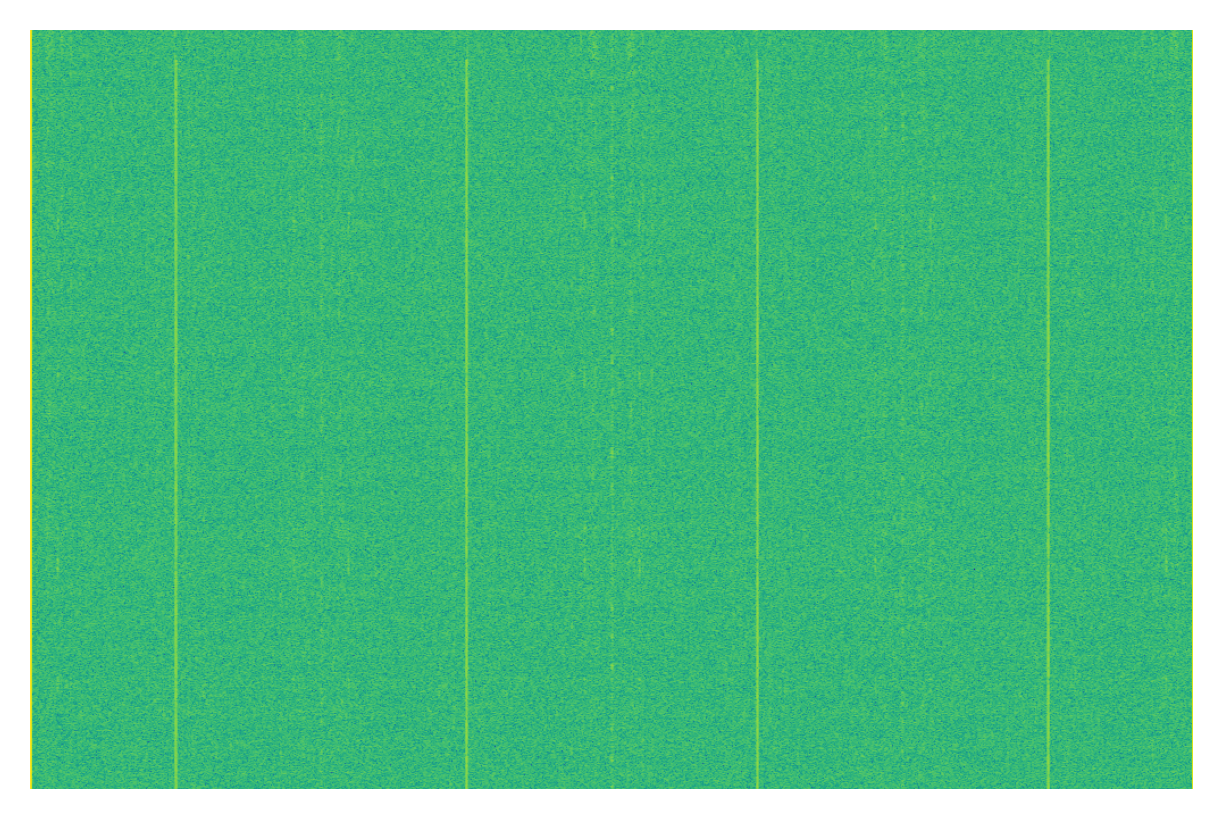

In [98]:
# Random drone data
drone_data = os.path.join(hackrf_path, 'drone/15edd400-1ddb-416b-8327-a076f396b868_sweep.iq')
compute_spectrogram(drone_data, 6e9, 1024)

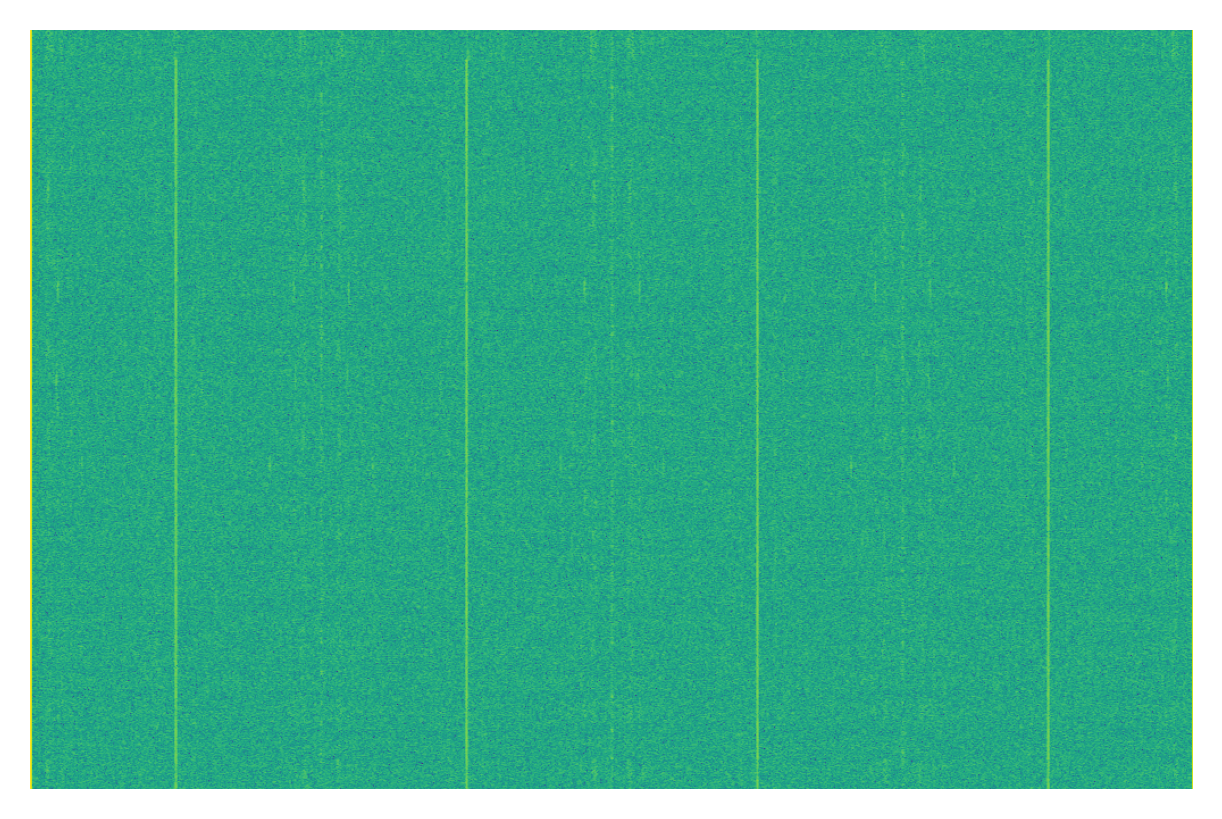

In [99]:
# Random no drone data
nodrone_data = os.path.join(hackrf_path, 'nodrone/0e12219c-0b49-4448-b551-d5a6e4aeb1c9_sweep.iq')
compute_spectrogram(nodrone_data, 6e9, 1024)

In [94]:
def compute_waterfall(sample_complex, plot = True):
    spectrum, _, _ = plt.mlab.specgram(sample_complex)
    spectrum = 10*np.log10(spectrum)
    spectrum_image = Image.fromarray(spectrum)
    waterfall = np.asarray(spectrum_image.resize((999, 999)))
    if plot:
        plt.imshow(waterfall)
        plt.show()
    return spectrum, waterfall

In [95]:
# Drone
sample_rate = 20e6
file_path = get_rand_file(hackrf_path, drone=True)
iq_data = load_iq_data(file_path)
segment_samples = int(sample_rate * 1.0)
complex_data = get_complex_segment(iq_data, 0, segment_samples) 


_, waterfall = compute_waterfall(complex_data)

../data/raw/hackrf/drone


NameError: name 'get_complex_segment' is not defined

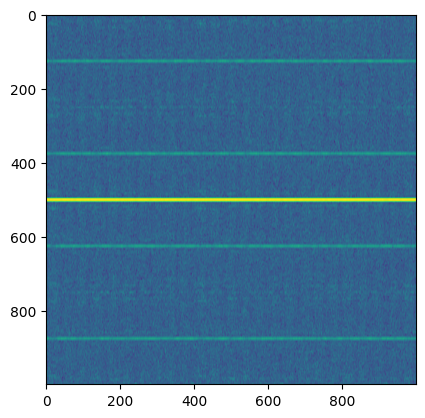

In [33]:
# No drone
file_path = get_rand_file(hackrf_path, drone=False)
iq_data = load_iq_data(file_path)
segment_samples = int(sample_rate * 1)
complex_data = get_complex_segment(iq_data, 0, segment_samples) 


_, waterfall = compute_waterfall(complex_data)

## Plotting raw data

../data/raw/hackrf/nodrone


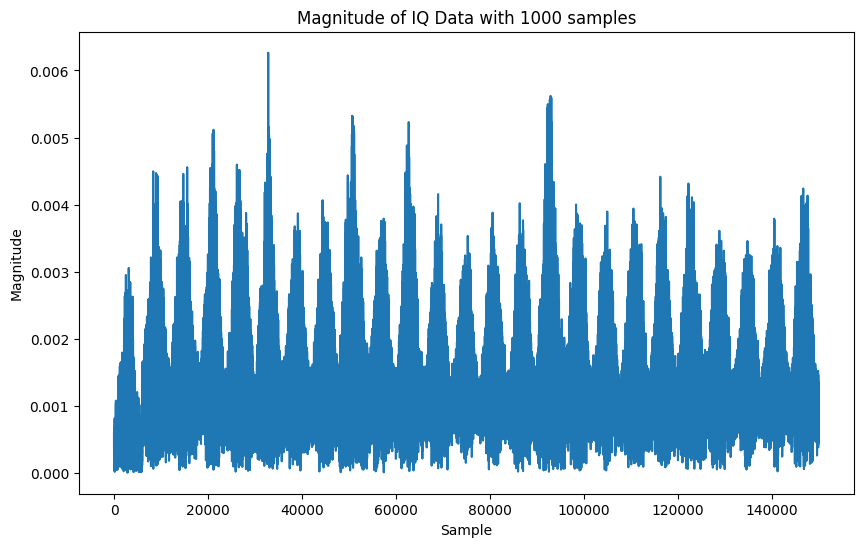

In [53]:
def plot_raw_data(file_path, samples=1000):
    iq_data = np.fromfile(file_path, dtype=np.complex64)
    segment_samples = int(sample_rate * 1.0)
    plt.figure(figsize=(10, 6))
    plt.plot(np.abs(iq_data[:segment_samples]))
    plt.title(f"Magnitude of IQ Data with {samples} samples")
    plt.xlabel("Sample")
    plt.ylabel("Magnitude")
    plt.show()
    
file_path = get_rand_file(hackrf_path, False)
plot_raw_data(file_path)

## Converting into spectrograms

Here, we use the librosa library to scale the data, perform short-time Fourier Transform, and develop spectrograms for each segment. We use the 'hamming' window to smooth the edges of each chunk to avoid artifacts. The amplitudes of the frequency is then converted to decibels.

In [ ]:
for folder in os.listdir(hackrf_path):
    folder_path = os.path.join(hackrf_path, folder)

    if not os.path.isdir(folder_path):
        continue
    
    export_path = os.path.join(input_path, folder)
    os.makedirs(export_path, exist_ok=True)
    
    for file in os.listdir(folder_path):
        if file.endswith('.iq'):
            file_path = os.path.join(folder_path, file)
            export_file = os.path.join(export_path, f"{os.path.splitext(file)[0]}.png")
            create_spectrogram(file_path, export_file, sample_rate)

print("Spectrograms created successfully.")

## Spectrograms to feature matrix for models

In [ ]:
def standardize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

Opens spectrogram images and converts into grayscale (just to make sure). These images are then rotated 270 degrees, min-max normalized, and reshaped to a 1D array. All these flattened images are stacked on top of each other to build our feature matrix.

In [ ]:
X_list = []
y = []

for drone in ['ar', 'bepop', 'bg', 'phantom']:
    pngs_path = os.path.join(input_path, drone)
    if not os.path.exists(pngs_path):
        print(f"Warning: Directory not found: {pngs_path}")
        continue
    
    drone_pngs_path = [os.path.join(pngs_path, f) for f in os.listdir(pngs_path) if f.endswith('.png')]
    
    for png_path in drone_pngs_path:
        img = np.array(Image.open(png_path).convert('L'))
        x = np.rot90(img, k=3)  # rotate
        x = standardize(x)
        x = x.reshape(1, IMG_SIZE*IMG_SIZE)
        
        X_list.append(x)
        y.append(drone)

X = np.vstack(X_list)
X = pd.DataFrame(X, columns=[f'p{i+1}' for i in range(IMG_SIZE*IMG_SIZE)])
df = pd.concat([pd.DataFrame({'y': y}), X], axis=1)

## PCA

In [ ]:
from sklearn.decomposition import PCA

pca_df = df.copy()
label_mapping = {'bg': 0, 'ar': 1, 'phantom': 2}
pca_df['y'] = pca_df['y'].map(label_mapping)

X = pca_df.drop(['y'], axis=1)
y = pca_df['y']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='Background')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='AR')
plt.scatter(X_pca[y == 2, 0], X_pca[y == 2, 1], label='Phantom')
plt.legend()
plt.title('PCA of Spectrogram Data')
plt.show()

There is clear separation between each drone and background points.

## Split data into training and testing

For anomaly detection cases, we don't care about specific drones quite yet. Due to this, we map every drone label as a "drone" with label 1.

In [ ]:
df['y'] = df['y'].map(lambda x: 0 if x == 'bg' else 1)

X = df.drop(['y'], axis=1)
y = df['y']

X_bg = X[y == 0]
X_drone = X[y == 1]

# Split background data into train and test sets
X_bg_train, X_bg_test = train_test_split(X_bg, test_size=0.2, random_state=42)

# Use all drone data and some background data for testing
X_test = pd.concat([X_bg_test, X_drone])
y_test = pd.concat([pd.Series([0] * len(X_bg_test)), pd.Series([1] * len(X_drone))])

print("Full dataset distribution:")
print(y.value_counts(normalize=True))

print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))

## Z-score for anomaly detection (current implementation)

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [ ]:
def z_score_anomaly_detector(X_train, X_test, threshold=3):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_bg_train)
    X_test_scaled = scaler.transform(X_test)
    
    mean = np.mean(X_train_scaled, axis=0)
    std = np.std(X_train_scaled, axis=0)

    z_scores = np.abs((X_test_scaled - mean) / std)

    # Flag as anomaly if any feature's z-score exceeds the threshold
    max_z_scores = np.max(z_scores, axis=1)
    return max_z_scores, pd.Series(np.where(max_z_scores > threshold, 1, 0))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

thresholds = [3, 3.5, 4, 4.5, 5]
for threshold in thresholds:
    z_scores, y_pred = z_score_anomaly_detector(X_bg_train, X_test, threshold=threshold)
    print(f"Results with threshold {threshold}:")
    print(classification_report(y_test, y_pred))

In [ ]:
z_scores, y_pred = z_score_anomaly_detector(X_bg_train, X_test, threshold=5)
print(classification_report(y_test, y_pred))
disp_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

# Isolation forest

In [ ]:
from sklearn.ensemble import IsolationForest

Contamination level is basically the percent of anomalies expected.

In [ ]:
iso_forest = IsolationForest(contamination=0.14)
iso_forest.fit(X_bg_train)

In [ ]:
iso_forest.get_params()

In [ ]:
y_pred_iso = iso_forest.predict(X_test)

In [ ]:
print(y_pred_iso)

In [ ]:
test_iso_predictions = (y_pred_iso == -1).astype(int)

In [ ]:
def evaluate_predictions(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    disp_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

In [ ]:
evaluate_predictions(y_test, test_iso_predictions)

### Using custom threshold with isolation forest anomaly scores

The decision function computes the anomaly score for each sample. The decision score is based on the average path length to isolate a sample. This was just for me to understand the how contamination and the decision function worked.

In [ ]:
# Get anomaly scores
train_iso_scores = iso_forest.decision_function(X_bg_train)
test_iso_scores = iso_forest.decision_function(X_test)

In [ ]:
threshold = np.percentile(train_iso_scores, 10)  # bottom 10% as anomalies
custom_iso_predictions = np.where(test_iso_scores < threshold, 1, 0)

In [ ]:
evaluate_predictions(y_test, custom_iso_predictions)

## Local Outlier Factor (LOF)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(contamination=0.1, novelty=True)
lof.fit(X_bg_train)

In [ ]:
y_pred_lof = lof.predict(X_test)

In [ ]:
print(y_pred_lof)

In [ ]:
test_lof_predictions = (y_pred_lof == -1).astype(int)
print(test_lof_predictions)

In [ ]:
evaluate_predictions(y_test, test_lof_predictions)

## Cross validation

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

def custom_cross_validation(X, y, n_splits=5):
    # Separate background and drone data
    X_bg = X[y == 0]
    X_drone = X[y == 1]
    y_bg = y[y == 0]
    y_drone = y[y == 1]

    # Create stratified k-fold for background data
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores = []

    for fold, (train_index, val_index) in enumerate(skf.split(X_bg, y_bg), 1):
        # Split background data
        X_bg_train, X_bg_val = X_bg.iloc[train_index], X_bg.iloc[val_index]
        
        # Combine validation background data with all drone data for testing
        X_val = pd.concat([X_bg_val, X_drone])
        y_val = pd.concat([pd.Series([0] * len(X_bg_val)), pd.Series([1] * len(X_drone))])
        
        # Train Isolation Forest
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        iso_forest.fit(X_bg_train)
        
        # Predict anomaly scores
        anomaly_scores = -iso_forest.decision_function(X_val)
        
        # Calculate AUC-ROC score
        auc_score = roc_auc_score(y_val, anomaly_scores)
        scores.append(auc_score)
        
        print(f"Fold {fold} AUC-ROC: {auc_score:.3f}")
    
    print(f"\nMean AUC-ROC: {np.mean(scores):.3f} (+/- {np.std(scores) * 2:.3f})")
    
    return scores
cv_scores = custom_cross_validation(X, y)

In [ ]:
import sys
import numpy as np
import pandas as pd
import sklearn
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")